## **Data Load**

In [3]:
# import all library
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
import tracemalloc
from scipy.linalg import orth

In [105]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


## **Q2. Incremental PCA**

creating subdatasets

In [106]:
x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

x_subs = [x_sub1, x_sub2, x_sub3, x_sub4]
y_subs = [y_sub1, y_sub2, y_sub3, y_sub4]

Eigenvecs 직접 구하기!

In [13]:
def get_mean_cov_mat(x_train):
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)
    A = x_train - x_train_bar
    S = np.matmul(A, A.T) / A.shape[1]
    return x_train_bar, S

In [14]:
def get_sorted_egivecs(n_components, eigvals, eigvecs):
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]
    eigvecs_n_comp = eigvecs[:, :n_components]

    return eigvecs_n_comp

In [71]:
def inc_pca(n_components, x_sub1, x_sub2, x_sub3, x_sub4, y_train, x_test, y_test):
    x_bar1, S_1 = get_mean_cov_mat(x_sub1)
    x_bar2, S_2 = get_mean_cov_mat(x_sub2)
    x_bar3, S_3 = get_mean_cov_mat(x_sub3)
    x_bar4, S_4 = get_mean_cov_mat(x_sub4)

    # only measure eigen-decomposition
    tracemalloc.start()
    start_time = time.perf_counter()
    # Get eigenvectors from each sub dataset
    eigvals1, eigvecs1 = np.linalg.eigh(S_1)
    eigvals2, eigvecs2 = np.linalg.eigh(S_2)
    eigvals3, eigvecs3 = np.linalg.eigh(S_3)
    eigvals4, eigvecs4 = np.linalg.eigh(S_4)

    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    P1 = get_sorted_egivecs(n_components, eigvals1, eigvecs1)
    P2 = get_sorted_egivecs(n_components, eigvals2, eigvecs2)
    P3 = get_sorted_egivecs(n_components, eigvals3, eigvecs3)
    P4 = get_sorted_egivecs(n_components, eigvals4, eigvecs4)


    # Incremental PCA -> merge
    combined_matrix = np.hstack((P1, P2))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    combined_matrix = np.hstack((P_new, P3))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    combined_matrix = np.hstack((P_new, P4))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    # mean update
    # x_bar = (x_bar1 + x_bar2 + x_bar3 + x_bar4) / 4
    x_bar = np.average(x_train, axis=1).reshape(-1,1)

    # Get reconstruction Error
    A_test = x_test - x_bar
    W_test = np.matmul(P_new.T, A_test)
    x_test_rec = x_bar + np.matmul(P_new, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))
    print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.2f}")

    # Get accuracy
    nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

    x_train_proj = np.matmul(P_new.T, x_train - x_bar)
    x_test_proj = np.matmul(P_new.T, x_test - x_bar)

    nn.fit(x_train_proj.T, y_train.reshape(-1))

    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    
    return run_time, peak_memory
    
run_time, peak_memory = inc_pca(25, x_sub1, x_sub2, x_sub3, x_sub4, y_train, x_test, y_test)

print(f"Peak memory usage: {peak_memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")

Reconstruction Error with eigenvectors (MAE): 15.01
Accuracy: 59.62%
Peak memory usage: 212.428922 MB
Execution Time: 3.91355758 seconds


In [63]:
def pca(n_components, x_train, y_train, x_test, y_test):
    x_bar, S = get_mean_cov_mat(x_train)

    # only measure eigen-decomposition
    tracemalloc.start()
    start_time = time.perf_counter()
    # Get eigenvectors from each sub dataset
    eigvals, eigvecs = np.linalg.eigh(S)

    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    P = get_sorted_egivecs(n_components, eigvals, eigvecs)

    # Get reconstruction Error
    A_test = x_test - x_bar
    W_test = np.matmul(P.T, A_test)
    x_test_rec = x_bar + np.matmul(P, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))
    print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.2f}")

    # Get accuracy
    nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

    x_train_proj = np.matmul(P.T, x_train - x_bar)
    x_test_proj = np.matmul(P.T, x_test - x_bar)

    nn.fit(x_train_proj.T, y_train.reshape(-1))

    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return run_time, peak_memory
    

run_time, peak_memory = pca(30, x_train, y_train, x_test, y_test)

print(f"Peak memory usage: {peak_memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")


Reconstruction Error with eigenvectors (MAE): 13.47
Accuracy: 63.46%
Peak memory usage: 53.107698 MB
Execution Time: 1.09079983 seconds


Using PCA library

In [170]:
def ipca_nn(n_components, x_subs, y_train, x_test, y_test):
    # Step 1: Perform PCA on the original and new data separately
    pca1 = PCA(n_components=n_components)
    pca2 = PCA(n_components=n_components)
    pca3 = PCA(n_components=n_components)
    pca4 = PCA(n_components=n_components)

    # Start: time and memory measure
    tracemalloc.start()
    start_time = time.perf_counter()

    P1 = pca1.fit(x_subs[0].T).components_.T
    P2 = pca2.fit(x_subs[1].T).components_.T
    P3 = pca3.fit(x_subs[2].T).components_.T
    P4 = pca4.fit(x_subs[3].T).components_.T

    # End: time and memory measure
    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Incrementally merge each eigenvectors
    combined_matrix = np.hstack((P1, P2))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    combined_matrix = np.hstack((P_new, P3))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    combined_matrix = np.hstack((P_new, P4))
    Phi = orth(combined_matrix) 
    P_new = Phi[:, :n_components]

    # Get mean vector
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)

    # Get reconstruction error
    A_test = x_test - x_train_bar
    W_test = np.matmul(P_new.T, A_test)
    x_test_rec = x_train_bar + np.matmul(P_new, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))


    # Applying NN algorithm
    x_train_proj = np.matmul(P_new.T, x_train - x_train_bar)
    x_test_proj = np.matmul(P_new.T, x_test - x_train_bar)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)

    return accuracy, rec_err, run_time, peak_memory

accuracy, rec_err, run_time, peak_memory = ipca_nn(5, x_subs, y_train, x_test, y_test)

print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.3f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Peak memory usage: {peak_memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")

Reconstruction Error with eigenvectors (MAE): 20.729
Accuracy: 33.65%
Peak memory usage: 4.128385 MB
Execution Time: 0.06791062 seconds


In [171]:
def batch_pca_nn(n_components, x_train, y_train, x_test, y_test):
    pca = PCA(n_components=n_components)

    # Start: time and memory measure
    tracemalloc.start()
    start_time = time.perf_counter()

    P = pca.fit(x_train.T).components_.T

    # End: time and memory measure
    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Get mean vector
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)

    # Get reconstruction error
    A_test = x_test - x_train_bar
    W_test = np.matmul(P.T, A_test)
    x_test_rec = x_train_bar + np.matmul(P, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))


    # Applying NN algorithm
    x_train_proj = np.matmul(P.T, x_train - x_train_bar)
    x_test_proj = np.matmul(P.T, x_test - x_train_bar)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)

    return accuracy, rec_err, run_time, peak_memory

accuracy, rec_err, run_time, peak_memory = batch_pca_nn(5, x_train, y_train, x_test, y_test)

print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.3f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Peak memory usage: {peak_memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")

Reconstruction Error with eigenvectors (MAE): 20.203
Accuracy: 40.38%
Peak memory usage: 9.602209 MB
Execution Time: 0.02138129 seconds


In [172]:
def sub1_pca_nn(n_components, x_train, y_train, x_test, y_test):
    pca = PCA(n_components=n_components)

    # Start: time and memory measure
    tracemalloc.start()
    start_time = time.perf_counter()

    P = pca.fit(x_sub1.T).components_.T

    # End: time and memory measure
    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Get mean vector
    x_sub1_bar = np.average(x_sub1, axis=1).reshape(-1,1)

    # Get reconstruction error
    A_test = x_test - x_sub1_bar
    W_test = np.matmul(P.T, A_test)
    x_test_rec = x_sub1_bar + np.matmul(P, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))


    # Applying NN algorithm
    x_train_proj = np.matmul(P.T, x_train - x_sub1_bar)
    x_test_proj = np.matmul(P.T, x_test - x_sub1_bar)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)

    return accuracy, rec_err, run_time, peak_memory

accuracy, rec_err, run_time, peak_memory = sub1_pca_nn(5, x_train, y_train, x_test, y_test)

print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.3f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Peak memory usage: {peak_memory / 10**6} MB")
print(f"Execution Time: {run_time:.8f} seconds")

Reconstruction Error with eigenvectors (MAE): 23.393
Accuracy: 34.62%
Peak memory usage: 3.134989 MB
Execution Time: 0.01295571 seconds


In [173]:
# Get Average Result
def avg_results(num_iter, func, num_bases, x_train, y_train, x_test, y_test):
    accuracy_avg, rec_err_avg, run_time_avg, peak_memory_avg = 0,0,0,0

    for i in range(num_iter):
        accuracy, rec_err, run_time, peak_memory = func(num_bases, x_train, y_train, x_test, y_test)
    
        accuracy_avg += accuracy
        rec_err_avg += rec_err
        run_time_avg += run_time
        peak_memory_avg += peak_memory
    
    accuracy_avg /= num_iter
    rec_err_avg /= num_iter
    run_time_avg /= num_iter
    peak_memory_avg /= num_iter

    return accuracy_avg, rec_err_avg, run_time_avg,  peak_memory_avg

In [178]:
num_base_vecs = []

ipca_acc_result = []
batch_acc_result = []
sub1_acc_result = []

ipca_rec_err_result = []
batch_rec_err_result = []
sub1_rec_err_result = []

ipca_runtime_result = []
batch_runtime_result = []
sub1_runtime_result = []

ipca_peak_mem_result = []
batch_peak_mem_result = []
sub1_peak_mem_result = []


for i in range(1, 21):
    num_bases = 5*i
    num_base_vecs.append(num_bases)
    
    # Get each PCA result
    ipca_accuracy, ipca_rec_err, ipca_run_time, ipca_peak_memory = avg_results(15, ipca_nn, num_bases, x_subs, y_train, x_test, y_test)
    batch_accuracy, batch_rec_err, batch_run_time, batch_peak_memory = avg_results(15, batch_pca_nn, num_bases, x_train, y_train, x_test, y_test)
    sub1_accuracy, sub1_rec_err, sub1_run_time, sub1_peak_memory = avg_results(15, sub1_pca_nn, num_bases, x_train, y_train, x_test, y_test)

    # accuracy arrays
    ipca_acc_result.append(ipca_accuracy)
    batch_acc_result.append(batch_accuracy)
    sub1_acc_result.append(sub1_accuracy)

    # reconstruction error arrays
    ipca_rec_err_result.append(ipca_rec_err)
    batch_rec_err_result.append(batch_rec_err)
    sub1_rec_err_result.append(sub1_rec_err)

    # runtime arrays -> seconds
    ipca_runtime_result.append(ipca_run_time)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)
    

    # peak memory arrays -> Mega Bite (MB)
    ipca_peak_mem_result.append(ipca_peak_memory / 10**6)
    batch_peak_mem_result.append(batch_peak_memory / 10**6)
    sub1_peak_mem_result.append(sub1_peak_memory / 10**6)

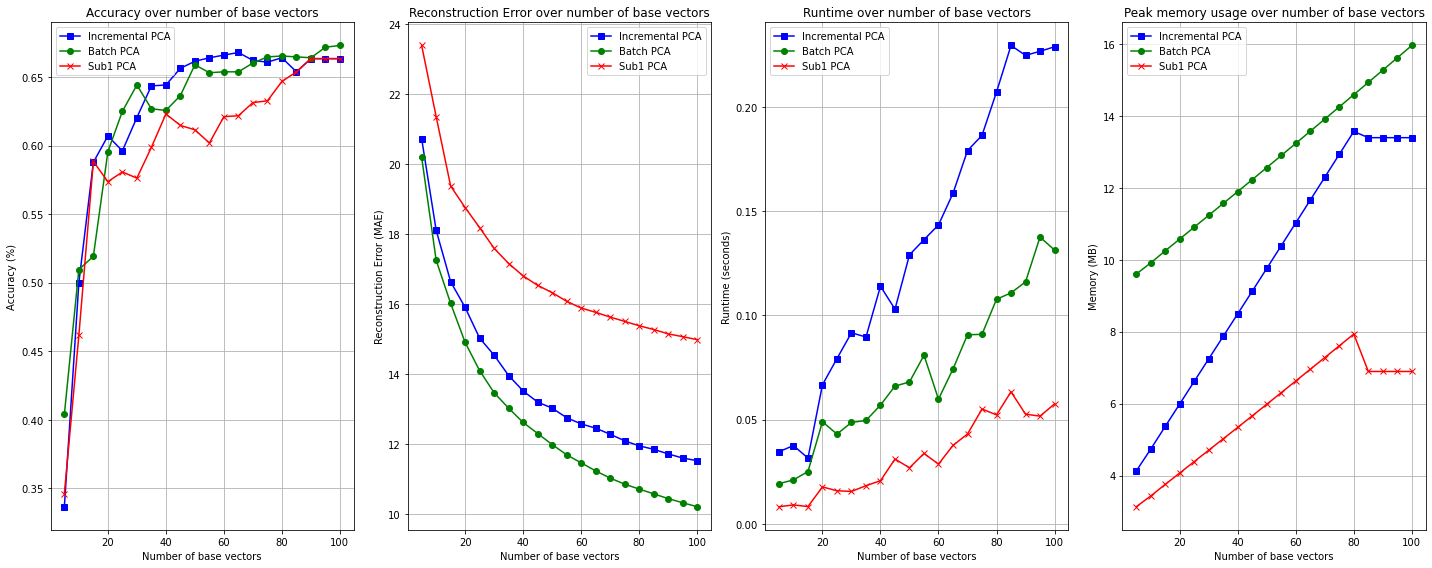

In [179]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, ipca_acc_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_acc_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_acc_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy over number of base vectors')
axes[0].legend()
axes[0].grid(True)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, ipca_rec_err_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_rec_err_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_rec_err_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors')
axes[1].set_ylabel('Reconstruction Error (MAE)')  # Customize based on your runtime units
axes[1].set_title('Reconstruction Error over number of base vectors')
axes[1].legend()
axes[1].grid(True)

# Plot runtime on the second subplot
axes[2].plot(num_base_vecs, ipca_runtime_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[2].plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[2].plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[2].set_xlabel('Number of base vectors')
axes[2].set_ylabel('Runtime (seconds)')  # Customize based on your runtime units
axes[2].set_title('Runtime over number of base vectors')
axes[2].legend()
axes[2].grid(True)

# Plot Peak memory usage on third subplot
axes[3].plot(num_base_vecs, ipca_peak_mem_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[3].plot(num_base_vecs, batch_peak_mem_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[3].plot(num_base_vecs, sub1_peak_mem_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[3].set_xlabel('Number of base vectors')
axes[3].set_ylabel('Memory (MB)')  # Customize based on your runtime units
axes[3].set_title('Peak memory usage over number of base vectors')
axes[3].legend()
axes[3].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()